***Import Libraries***

In [1]:
"""This program bilinearizes 3R planar dyanmics using koopman theory and autoencoder to map"""
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools

import tensorflow as tf

***Simulation Parameters***

In [21]:
dt = 0.005 #time step
num_snaps = 1000 # no. of snapshots
T = np.linspace(0,num_snaps*dt, num_snaps+1)
num_train = 100 # no. of training examples
num_val = int(0.25*num_train) # no of testing examples
num_traj = num_train+num_val #no of trajectories
num_states = 6 # no. of states
num_inputs = 3 # no. of inputs

***Robot Parameters***

In [22]:
robot_pars = {}
# link lengths
robot_pars['a1'] = 0.33
robot_pars['a2'] = 0.33
robot_pars['a3'] = 0.33

#link masses
robot_pars['m1'] = 0.1
robot_pars['m2'] = 0.1
robot_pars['m3'] = 0.1

# link inertias
robot_pars['I1'] = 1
robot_pars['I2'] = 1
robot_pars['I3'] = 1

#position of CM
robot_pars['l1'] = 0.33/2
robot_pars['l2'] = 0.33/2
robot_pars['l3'] = 0.33/2

#dynamic friction coefficient
robot_pars['fd'] = 0.1


***Data Generation for 3R***

***Plotting the trajectories***

In [4]:
# Function for dynamics
def dataset_dyn_gen_3R(dt,num_traj,num_snaps,num_states,num_inputs, robot_pars):
  #define parameters
  # link lengths
  a1 = robot_pars['a1']
  a2 = robot_pars['a2']
  a3 = robot_pars['a3']

  #link masses
  m1 = robot_pars['m1']
  m2 = robot_pars['m2']
  m3 = robot_pars['m3']

  # link inertias
  I1 = robot_pars['I1']
  I2 = robot_pars['I2']
  I3 = robot_pars['I3']

  #position of CM
  l1 = robot_pars['l1']
  l2 = robot_pars['l2']
  l3 = robot_pars['l3']

  #dynamic friction coefficient
  fd = robot_pars['fd']

  # gravity
  g = 9.81*0

  # matrix initializations
  X = np.empty((num_traj,num_snaps+1,num_states)) # cartesian state matrix
  U = np.empty((num_traj,num_snaps,num_inputs)) # input matrix
  x_end = np.empty((num_traj,num_snaps+1,2)) # position of end effector

  for i in range(num_traj):
    # initialize the values for the trajectory
      # joint angles
    X[i,0,0:3] = np.pi*(2*np.random.rand(1,1,3)-1) # theta values
      # joint velocities
    X[i,0,3:6] = 0.1*(2*np.random.rand(1,1,3)-1) # theta values
    x_end[i,0,0]= a1*np.cos(X[i,0,0])+a2*np.cos(X[i,0,0]+X[i,0,1])+a3*np.cos(X[i,0,0]+X[i,0,1]+X[i,0,2])
    x_end[i,0,1]= a1*np.sin(X[i,0,0])+a2*np.sin(X[i,0,0]+X[i,0,1])+a3*np.sin(X[i,0,0]+X[i,0,1]+X[i,0,2])


    for j in range(num_snaps):

        #define thetas and theta_dots for convenience
        th1 = X[i,j,0]
        th2 = X[i,j,1]
        th3 = X[i,j,2]
        th1_dot = X[i,j,3]
        th2_dot = X[i,j,4]
        th3_dot = X[i,j,5]

        theta_dot = X[i,j,3:6].reshape(num_inputs,1)


        # mass matrix
        m11 = I1+I2+I3+m1*l1**2+m2*(a1**2+l2**2+2*a1*l2*np.cos(th2))+m3*(a1**2+a2**2+l3**2+2*a1*a2*np.cos(th2)+2*a1*l3*np.cos(th2+th3)+2*a2*l3*np.cos(th3))
        m22 = I2+I3+m2*l2**2+m3*(a2**2+l3**2+2*a2*l3*np.cos(th3))
        m33 = I3+m3*l3**2
        m12 = I2+I3+m2*(l2**2+a1*l2*np.cos(th2))+m3*(a2**2+l3**2+a1*a2*np.cos(th2)+a1*l3*np.cos(th2+th3)+2*a2*l3*np.cos(th3))
        m21 = m12
        m13 = I3+m3*(l3**2+a1*l3*np.cos(th2+th3)+a2*l3*np.cos(th3))
        m31 = m13
        m23 = I3+m3*(l3**2+a2*l3*np.cos(th3))
        m32 = m23


        M = np.array([[m11,m12,m13],[m21,m22,m23],[m31,m32,m33]])
              
        # coriolis terms
        c11 = -(m3*a1*l3*np.sin(th2+th3)+m3*a2*l3*np.sin(th3))*th3_dot-(m2+m3*a1*a2*np.sin(th2)+a1*l2*np.sin(th2)+m3*a1*l3*np.sin(th2+th3))*th2_dot
        c22 = -m3*a2*l3*np.sin(th3)*th3_dot
        c33 = -(m3*a1*a2*np.sin(th2))*th2_dot-(m3*a2*l3*np.sin(th3))*th3_dot
        c12 = -(m2*a1*l2*np.sin(th2)+m3*a1*l3*np.sin(th2+th3)+m3*a1*a2*np.sin(th2))*th1_dot-(m3*a1*a2*np.sin(th2)+m3*a1*l3*np.sin(th2+th3)+m2*a1*l2*np.sin(th2))*th2_dot-(m3*a2*l3*np.sin(th3)+m3*a1*l3*np.sin(th2+th3))*th3_dot
        c13 = -(m3*a1*l3*np.sin(th2+th3)+m3*a2*l3*np.sin(th3))*th1_dot-(m3*a1*l3*np.sin(th2+th3)+m3*a2*l3*np.sin(th3))*th2_dot-(m3*a2*l3*np.sin(th2)+m3*a1*l3*np.sin(th2+th3))*th3_dot
        c21 = (m2*a1*l2*np.sin(th2)+m3*a1*a2*np.sin(th2)+m3*a1*l3*np.sin(th2+th3))*th1_dot-(m3*a2*l3*np.sin(th3))*th3_dot
        c23 = -(m3*a2*l3*np.sin(th3))*th1_dot-(m3*a2*l3*np.sin(th3))*th2_dot-(m3*a2*l3*np.sin(th3))*th3_dot
        c31 = (m3*a1*l3*np.sin(th2+th3)+m3*a2*l3*np.sin(th3))*th1_dot+(m3*a2*l3*np.sin(th3))*th2_dot
        c32 = (m3*a2*l3*np.sin(th3))*th1_dot+(m3*a2*l3*np.sin(th3))*th2_dot-(m3*a2*l3*np.sin(th3))*th3_dot

        C = np.array([[c11,c12,c13],[c21,c22,c23],[c31,c32,c33]])


        # gravity terms
        g1 = (m2*l2+m3*a2)*g*np.cos(th1+th2)+m3*l3*g*np.cos(th1+th2+th3)+(m1*l1+m3*a1+m2*a1)*g*np.cos(th1)
        g2 = (m2*l2+m3*a2)*g*np.cos(th1+th2)+m3*l3*g*np.cos(th1+th2+th3)
        g3 = m3*l3*g*np.cos(th1+th2+th3)

              
        G = np.array([[g1],[g2],[g3]])

        # inputs
        U[i,j,:] = 1*(2*np.random.rand(1,1,3)-1)
        tau = np.array([[U[i,j,0]],[U[i,j,1]],[U[i,j,2]]])

        # theta evolution
        th_ddot = np.matmul(np.linalg.inv(M),(tau-G-np.matmul(C,theta_dot)-(fd*theta_dot))).reshape(1,1,3)
        X[i,j+1,3:6] = X[i,j,3:6] + th_ddot*dt
        X[i,j+1,0:3] = X[i,j,0:3] + X[i,j,3:6]*dt +(1/2)*th_ddot*dt**2

        x_end[i,j+1,0]= a1*np.cos(X[i,j+1,0])+a2*np.cos(X[i,j+1,0]+X[i,j+1,1])+a3*np.cos(X[i,j+1,0]+X[i,j+1,1]+X[i,j+1,2])
        x_end[i,j+1,1]= a1*np.sin(X[i,j+1,0])+a2*np.sin(X[i,j+1,0]+X[i,j+1,1])+a3*np.sin(X[i,j+1,0]+X[i,j+1,1]+X[i,j+1,2])

  return x_end,X,U

In [5]:
# Trajectories
X_end,X_full, U_full = dataset_dyn_gen_3R(dt,num_traj, num_snaps,num_states,num_inputs,robot_pars)
print(X_end.shape, X_full.shape,U_full.shape)

(125, 1001, 2) (125, 1001, 6) (125, 1000, 3)


In [6]:
X_full.T.shape

(6, 1001, 125)

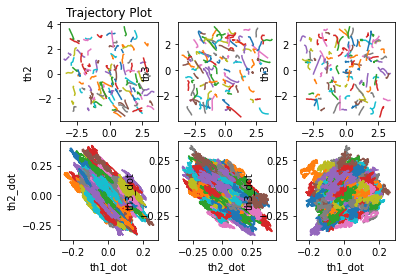

In [7]:
"""Training dataset visualization"""
#theta1 theta2 plot
plt.subplot(2,3,1)
plt.title("Trajectory Plot")
plt.xlabel("th1")
plt.ylabel("th2")
for i in range(num_traj):
  plt.plot(X_full[i,:,0],X_full[i,:,1])

#theta2 theta3 plot
plt.subplot(2,3,2)
plt.xlabel("th2")
plt.ylabel("th3")
for i in range(num_traj):
    plt.plot(X_full[i,:,1],X_full[i,:,2])

#theta1 theta3 plot
plt.subplot(2,3,3)
plt.xlabel("th1")
plt.ylabel("th3")
for i in range(num_traj):
    plt.plot(X_full[i,:,0],X_full[i,:,2])

#theta1_dot theta2_dot plot
plt.subplot(2,3,4)
plt.xlabel("th1_dot")
plt.ylabel("th2_dot")
for i in range(num_traj):
    plt.plot(X_full[i,:,3],X_full[i,:,4])

#theta2_dot theta3_dot plot
plt.subplot(2,3,5)
plt.xlabel("th2_dot")
plt.ylabel("th3_dot")
for i in range(num_traj):
    plt.plot(X_full[i,:,4],X_full[i,:,5])

#theta1_dot theta3_dot plot
plt.subplot(2,3,6)
plt.xlabel("th1_dot")
plt.ylabel("th3_dot")
for i in range(num_traj):
    plt.plot(X_full[i,:,3],X_full[i,:,5])



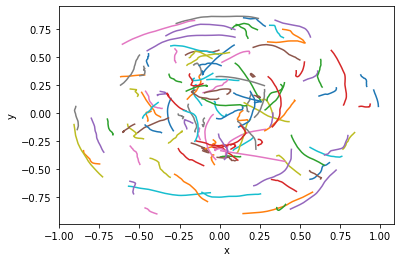

In [8]:
#x and y positions of the end effector

plt.xlabel("x")
plt.ylabel("y")
for i in range(num_traj):
    plt.plot(X_end[i,:,0],X_end[i,:,1])

***Training and validation datasets***

In [9]:
# split training and vaidation datasets
xs_train, us_train = X_full[:num_train,:,:],U_full[:num_train,:,:]
xs_val, us_val = X_full[num_train:,:,:],U_full[num_train:,:,:]

In [10]:
# import scipy.io
# Data_set = {"x_end": X_end, "X_full": X_full}
# scipy.io.savemat("Data_set.mat",Data_set)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

***Classes for Koopman bilinear Models***

In [12]:
# base class for koopman net

class KoopmanNet(nn.Module):
  def __init__(self, net_params, standardizer_x=None, standardizer_u=None):
    super(KoopmanNet, self).__init__()
    self.net_params = net_params
    self.standardizer_x = standardizer_x
    self.standardizer_u = standardizer_u
    self.encoder = None
    self.opt_parameter_encoder = []
    self.opt_parameters_dyn_mats = []
    self.x_running_mean = None
    self.x_running_var = None


  def construct_net(self):
    pass
  
  def forward(self, data):
    pass

  def process(self, data_x, data_u=None, downsample_rate = 1):
    pass
  
  def construct_dyn_mat(self):
    pass

  def loss(self, outputs, labels):
    n = self.net_params['state_dim']
    n_z = self.net_params['encoder_output_dim']
    override_C = self.net_params['override_C']
    
    #output = x_proj, x_prime_diff_pred, z_prime_diff_pred, z_prime_diff
    #ilabels =  [x,x_prime_diff]

    # next time step pred
    x_proj = outputs[:,:n]
    x = labels[:,:n]
    
    x_prime_diff_pred = outputs[:,n:2*n]
    x_prime_diff = labels[:, n:2*n]

    # next time step pred diff in lifted space
    z_prime_diff_pred = outputs[:, 2*n:2*n+n_z]
    z_prime_diff = outputs[:,2*n+n_z : 2*n+2*n_z]

    # l1 regularization
    alpha = self.net_params['lifted_loss_penalty']
    # criterion
    criterion = nn.MSELoss()

    #pred_loss = criterion(x_prime_pred,x_prime)
    if override_C:
        pred_loss = criterion(x_prime_diff_pred,torch.divide(x_prime_diff,self.loss_scaler_x[:n]))
    else:
        pred_loss = criterion(x_prime_diff_pred,x_prime_diff/self.loss_scaler_z)
        

    #proj_loss = reconstruction loss
    proj_loss = criterion(x_proj, x)

    #lifted state loss
    lifted_loss = criterion(z_prime_diff_pred, z_prime_diff/self.loss_scaler_z)/(n_z/n)
    l1_loss = 0.
    # l1 regulaization
    if 'l1_reg' in self.net_params and self.net_params['l1_reg'] > 0:
      l1_reg = self.net_params['l1_reg']
      l1_loss = l1_reg*self.get_l1_norm_()

    if override_C:
        total_loss = pred_loss + alpha*lifted_loss + l1_loss
    else:
        total_loss = proj_loss + pred_loss + alpha*lifted_loss + l1_loss
    return total_loss, pred_loss, alpha*lifted_loss

  # construct the autoencoder part
  def construct_encoder_(self):
    input_dim = self.net_params['state_dim']
    hidden_depth = self.net_params['encoder_hidden_depth']
    hidden_width = self.net_params['encoder_hidden_width']
    output_dim = self.net_params['encoder_output_dim']
    activation_type = self.net_params['activation_type']

    if hidden_depth > 0:
      # input layer
      self.encoder_fc_in = nn.Linear(input_dim,hidden_width)
      self.opt_parameter_encoder.append(self.encoder_fc_in.weight)
      self.opt_parameter_encoder.append(self.encoder_fc_in.bias)
      #the hidden laers will be passed as list elements to this module
      self.encoder_fc_hid = nn.ModuleList()

      # hidden layers
      for i in range(1, hidden_depth):
        self.encoder_fc_hid.append(nn.Linear(hidden_width,hidden_width))
        self.opt_parameter_encoder.append(self.encoder_fc_hid[-1].weight)
        self.opt_parameter_encoder.append(self.encoder_fc_hid[-1].bias)
    
      self.encoder_fc_out = nn.Linear(hidden_width,output_dim)
      self.opt_parameter_encoder.append(self.encoder_fc_out.weight)
      self.opt_parameter_encoder.append(self.encoder_fc_out.bias)
    
    #output layers
    else: # no hidden layers
      self.encoder_fc_out = nn.Linear(input_dim,output_dim)
      self.opt_parameter_encoder.append(self.encoder_fc_out.weight)
      self.opt_parameter_encoder.append(self.encoder_fc_out.bias)
    

    # activation functions
    if activation_type == 'relu':
      self.activation_fcn = F.relu

    if activation_type == 'elu':
      self.activation_fcn = nn.relu

    if activation_type == 'tanh':
      self.activation_fcn = torch.tanh

    if activation_type == 'sigmoid':
      self.activation_fcn = torch.sigmoid

    else:
      exit("Exit : invalid activation function")

  def encode_forward_(self,x): #encoder_forward_pass
    if self.net_params['encoder_hidden_depth'] > 0:
      x = self.activation_fcn(self.encoder_fc_in(x))
      
      for layer in self.encoder_fc_hid:
        x = self.activation_fcn(layer(x))
    
    x = self.encoder_fc_out(x)

    return x

  def encode(self, x):
    first_obs_const = int(self.net_params['first_obs_const'])
    n = self.net_params['state_dim']
    override_C = self.net_params['override_C']
    x_t = torch.from_numpy(x).float
    if override_C:
        z = np.concatenate((np.ones((x.shape[0], first_obs_const)), x[:, :n], self.encode_forward_(x_t).detach().numpy()), axis=1)
    else:
        z = np.concatenate((np.ones((x.shape[0], first_obs_const)), self.encode_forward_(x_t).detach().numpy()),  axis=1)
    return z
  
  def preprocess_data(self, data, standardizer):
    if standardizer is None:
      data_scaled = data
    else:
      data_scaled = np.array([standardizer.transform(d) for d in data])

    return data_scaled


In [13]:
# class for koopman net with control

class KoopmanNetCtrl(KoopmanNet):
    def __init__(self, net_params,standardizer_x=None, standardizer_u=None):
        super(KoopmanNetCtrl, self).__init__(net_params,standardizer_x=standardizer_x, standardizer_u=standardizer_u)

      # define a function to contruct net
    def construct_net(self):
        n = self.net_params['state_dim']
        m = self.net_params['ctrl_dim']
        encoder_output_dim = self.net_params['encoder_output_dim']
        # include constants in lifted states
        first_obs_const = self.net_params['first_obs_const'] #only one state
        override_C = self.net_params['override_C']
        # total no of lifted staes = states+constants+encoder output
        if override_C:
            self.n_tot = int(first_obs_const) + encoder_output_dim + n
        else:
            self.n_tot = int(first_obs_const) + encoder_output_dim

        self.construct_encoder_()
        # create the linear layer to move the states one step ahead
        # for drift
        self.koopman_fc_drift = nn.Linear(self.n_tot, self.n_tot-first_obs_const, bias = False)
        # actuation
        self.koopman_fc_act = nn.Linear(m*self.n_tot, self.n_tot-first_obs_const, bias = False)

        # get a fully connected layer to get back x
        if override_C:
            self.C = torch.cat((torch.zeros((n, first_obs_const)), torch.eye(n),torch.zeros((n, encoder_output_dim))), 1)
        else:
            self.projection_fc = nn.Linear(self.n_tot, n, bias = False)

    def forward(self, data):
        # data = [x, u, x_prime]
        #output = [x_proj,x_prime_pred, z_prime_pred, z_prime]
        n = self.net_params['state_dim']
        m = self.net_params['ctrl_dim']
        # include constants in lifted states
        first_obs_const = int(self.net_params['first_obs_const']) #only one state
        override_C = self.net_params['override_C'] 

        x = data[:, :n]
        u = data[:, n:n+m]
        x_prime = data[:,n+m:]

        # define the lifted states
        if override_C:
            z = torch.cat((torch.ones((x.shape[0], first_obs_const)),x[:,:n],self.encode_forward_(x)),1)
            z_prime_diff = self.encode_forward_(x_prime) - z[:,first_obs_const+n:]
        else:
            z = torch.cat((torch.ones((x.shape[0], first_obs_const)),self.encode_forward_(x)),1)
            z_prime_diff = self.encode_forward_(x_prime) - z[:,first_obs_const:]
            
        # bilinear states
        z_u = torch.cat([torch.transpose(torch.mul(torch.transpose(z, 0, 1), u_i), 0, 1) for u_i in torch.transpose(u, 0, 1)], 1)
        drift_matrix, act_matrix = self.construct_drift_act_matrix_()
        # predicted z_prime_diff
        #z_(k+1) - z_(k) = drift_fun(z_k) + act_fun(z_k*u_k) 
        z_prime_diff_pred = torch.matmul(z, torch.transpose(drift_matrix, 0, 1)) + torch.matmul(z_u, torch.transpose(act_matrix, 0, 1))

        # x_projected
        if override_C:
            x_proj = torch.matmul(z, torch.transpose(self.C,0,1))
            x_prime_diff_pred = torch.matmul(z_prime_diff_pred, torch.transpose(self.C,0,1))
            z_prime_diff_pred = z_prime_diff_pred[:,first_obs_const+n:]
        else:
            x_proj = self.projection_fc(z) 
            x_prime_diff_pred = self.projection_fc(z_prime_diff_pred)
            z_prime_diff_pred = z_prime_diff_pred[:,first_obs_const:]

        return torch.cat((x_proj, x_prime_diff_pred, z_prime_diff_pred, z_prime_diff),1)

    def construct_drift_act_matrix_(self): 
        n = self.net_params['state_dim']
        m = self.net_params['ctrl_dim']
        first_obs_const = int(self.net_params['first_obs_const'])
        const_obs_dyn_drift = torch.zeros((first_obs_const, self.n_tot)) # drift for the constant term
        drift_matrix = torch.cat((const_obs_dyn_drift, self.koopman_fc_drift.weight), 0)
        #drift_matrix = self.koopman_fc_drift.weight
        const_obs_dyn_act = torch.zeros((first_obs_const, m*self.n_tot)) # actuation for the constant term
        act_matrix = torch.cat((const_obs_dyn_act, self.koopman_fc_act.weight), 0)
        #act_matrix = self.koopman_fc_act.weight


        return drift_matrix, act_matrix

    def process(self, data_x, data_u = None, downsample_rate = 1, train_mode =True):
        n = self.net_params['state_dim']
        m = self.net_params['ctrl_dim']
        n_traj = data_x.shape[0]

        data_scaled_x = self.preprocess_data(data_x, self.standardizer_x)
        data_scaled_u = self.preprocess_data(data_u, self.standardizer_u)

        #data_scaled_x = data_x
        #data_scaled_u = data_u

        x = data_scaled_x[:, :-1, :]
        u = data_scaled_u
        x_prime = data_scaled_x[:,1:,:]

        order = 'F'
        n_data_pts = n_traj * (x.shape[1])
        x_flat = x.T.reshape((n, n_data_pts), order=order)
        u_flat = u.T.reshape((m, n_data_pts), order=order)
        x_prime_flat = x_prime.T.reshape((n, n_data_pts), order=order)

        X = np.concatenate((x_flat.T, u_flat.T, x_prime_flat.T), axis=1)
        #y = x_prime_flat.T
        y = np.concatenate((x_flat.T, x_prime_flat.T-x_flat.T), axis=1)

        if train_mode:
            self.loss_scaler_x = torch.Tensor(np.std(x_prime_flat[:n, :].T - x_flat[:n, :].T, axis=0))
            self.loss_scaler_z = np.std(x_prime_flat.T - x_flat.T)

        return X[::downsample_rate,:], y[::downsample_rate,:]


    def construct_dyn_mat(self): # take a look again
        n = self.net_params['state_dim']
        m = self.net_params['ctrl_dim']
        encoder_output_dim = self.net_params['encoder_output_dim']
        first_obs_const = int(self.net_params['first_obs_const'])
        override_C = self.net_params['override_C']
        if override_C:
            loss_scaler = np.concatenate((np.ones(first_obs_const), self.loss_scaler_x.numpy(), self.loss_scaler_z*np.ones(encoder_output_dim)))
        else:
            loss_scaler = np.concatenate((np.ones(first_obs_const), self.loss_scaler_z * np.ones(encoder_output_dim)))
        drift_matrix, act_matrix = self.construct_drift_act_matrix_()

        self.A = drift_matrix.data.numpy()
        self.A[first_obs_const:, :] = np.multiply(self.A[first_obs_const:, :],loss_scaler[first_obs_const:].reshape(-1, 1))
        self.A += np.eye(self.n_tot)

        #B_vec = act_matrix.data.numpy()
        #self.B = [np.multiply(B_vec[:, self.n_tot * ii:self.n_tot * (ii + 1)], loss_scaler.reshape(-1,1)) for ii in range(m)]
        self.B = act_matrix.data.numpy()
        for ii in range(m):
            self.B[:, self.n_tot * ii:self.n_tot * (ii + 1)] = np.multiply(self.B[:, self.n_tot * ii:self.n_tot * (ii + 1)], loss_scaler.reshape(-1,1))
        
        if not override_C:
            self.C = self.projection_fc.weight.detach().numpy()

    def get_l1_norm_(self):
          return torch.norm(self.koopman_fc_drift.weight.view(-1), p=1) + torch.norm(self.koopman_fc_act.weight.view(-1), p=1)

In [14]:
import torch.optim as optim
from torch.utils.data import random_split

In [15]:

import os
class KoopDNN():
  "class for nn based learning"
  def __init__(self, net, first_obs_const=True, dt = None):
    self.A = None
    self.B = None

    self.net = net
    self.optimizer = None
    self.C = None

    self.first_obs_const = first_obs_const
    self.dt = dt

    self.x_train = None
    self.u_train = None
    self.x_val = None
    self.u_val = None

  def set_datasets(self, x_train, u_train=None, x_val=None, u_val=None):
    self.x_train = x_train
    self.u_train = u_train

    self.x_val = x_val
    self.u_val = u_val

  def model_pipeline(self, net_params, print_epoch = True,early_stop=False, plot_data = False):
    self.net.net_params = net_params
    self.net.construct_net()
    self.set_optimizer_()

    X_train, y_train = self.net.process(self.x_train, data_u=self.u_train)
    X_val, y_val = self.net.process(self.x_val, data_u=self.u_val, train_mode=False)
    
    if plot_data:
      self.plot_train_data(X_train, y_train)

    X_train_t, y_train_t = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
    X_val_t, y_val_t = torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()
    dataset_train = torch.utils.data.TensorDataset(X_train_t, y_train_t)
    dataset_val = torch.utils.data.TensorDataset(X_val_t, y_val_t)

    self.train_model(dataset_train, dataset_val, print_epoch=print_epoch)

  def train_model(self, dataset_train, dataset_val, print_epoch = True, tune_run = False, early_stop = False,early_stop_crit=1e-3, early_stop_max_count=5,):
    trainloader = torch.utils.data.DataLoader(dataset_train, batch_size = self.net.net_params['batch_size'], shuffle = True)
    valloader = torch.utils.data.DataLoader(dataset_val, batch_size = self.net.net_params['batch_size'])

    val_loss_prev = np.inf
    no_improv_counter = 0
    self.train_loss_hist = []
    self.val_loss_hist = []
    for epoch in range(self.net.net_params['epochs']):
      running_loss = 0.0
      running_pred_loss = 0.0
      running_lifted_loss = 0.0
      epoch_steps = 0

      for data in trainloader:
        inputs, labels = data

        self.optimizer.zero_grad()
        output =self.net(inputs)
        loss, pred_loss, lifted_loss = self.net.loss(output, labels)
        loss.backward()
        self.optimizer.step()

        running_loss += loss.detach()
        running_pred_loss += pred_loss.detach()
        running_lifted_loss += lifted_loss.detach()
        epoch_steps += 1

      val_loss = 0.0
      val_pred_loss = 0.0
      val_lifted_loss = 0.0
      val_steps =0

      for data in valloader:
        with torch.no_grad():
          inputs, labels = data

          output = self.net(inputs)
          loss, pred_loss, lifted_loss = self.net.loss(output, labels)

          val_loss += float(loss.detach())
          val_pred_loss += float(pred_loss.detach())
          val_lifted_loss += float(lifted_loss.detach())
          val_steps += 1
  
  # Print epoch loss
      self.train_loss_hist.append((running_loss/epoch_steps, running_pred_loss/epoch_steps, running_lifted_loss/epoch_steps))
      self.val_loss_hist.append((val_loss/val_steps, val_pred_loss/val_steps, val_lifted_loss/val_steps))
      if print_epoch:
          print('Epoch %3d: train loss: %.10f, validation loss: %.10f' %(epoch + 1, self.train_loss_hist[-1][0], self.val_loss_hist[-1][0]))

      if early_stop:
        improvement = (val_loss/val_steps)/val_loss_prev
        if improvement >= 1 - early_stop_crit and improvement <= 1+early_stop_crit:
            no_improv_counter += 1
        else:
            no_improv_counter = 0

        if no_improv_counter >= early_stop_max_count:
            print('Early stopping activated, less than %.4f improvement for the last %2d epochs.'%(early_stop_crit, no_improv_counter))
            break
        val_loss_prev = val_loss/val_steps

    print("Finished Training")

  def test_loss(self, x_test, u_test = None):
    if u_test is None:
      X_test, y_test = self.net.process(x_test, train_model = False)
    else:
      X_test, y_test = self.net.process(x_test, data_u = u_test, train_mode = False)
    
    X_t, y_t = torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()
    dataset_test = torch.utils.data.TensorDataset(X_t, y_t)
    testloader = torch.utils.data.DataLoader(dataset_test, batch_size=self.net.net_params['batch_size'], shuffle=True)

    test_loss = 0.0
    test_steps = 0
    with torch.no_grad():
      for data in testloader:
        inputs, labels = data

        outputs = self.net(inputs)
        loss, _, _ = self.net.loss(outputs, labels)
        test_loss += loss.detach()
        test_steps += 1

    return test_loss/test_steps
  
  def construct_koopman_model(self):
      self.construct_dyn_mat_()

  def construct_dyn_mat_(self):
      self.net.construct_dyn_mat()
      self.A = self.net.A
      try:
        self.B = self.net.B
      except AttributeError:
        pass
      self.C = self.net.C

  def basis_encode(self, x):
      if self.net.standardizer_x is None:
        x_scaled = np.atleast_2d(x)
      else:
        x_scaled = self.net.standardizer_x.transform(x)

      return self.net.encode(x_scaled)

  def set_optimizer_(self):
    if self.net.net_params['optimizer'] == 'sgd':
        lr = self.net.net_params['lr']
        momentum = self.net.net_params['momentum']
        self.optimizer_encoder = optim.SGD(self.net.opt_parameters_encoder, lr=lr, momentum=momentum)
        self.optimizer_dyn_mats = optim.SGD(self.net.opt_parameters_dyn_mats, lr=lr, momentum=momentum)
    elif self.net.net_params['optimizer'] == 'adam':
        lr = self.net.net_params['lr']
        weight_decay = self.net.net_params['l2_reg']
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr, weight_decay=weight_decay)
    elif self.net.net_params['optimizer'] == 'adamax':
        lr = self.net.net_params['lr']
        weight_decay = self.net.net_params['l2_reg']
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr, weight_decay=weight_decay)

  # plotting methods

  def plot_train_data(self, X,y):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize = (15,5))
    ax = fig.add_subplot(121, projection = '3d')
    ax.scatter(X[:, 2], X[:, 3], y[:, 2], color="orange")
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel("$x_1'$")
    ax.set_title('One-step-ahead state, $x_1$')
    ax.view_init(30, 70)

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(X[:, 2], X[:, 3], y[:, 3], color="orange")
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel("$x_2'$")
    ax.set_title('One-step-ahead state, $x_2$')
    ax.view_init(30, 70)
    plt.show()

  def plot_learning_curve(self):
    import matplotlib.pyplot as plt

    train_loss = np.array(self.train_loss_hist)  # [[total loss, prediction loss, bilinearity loss]]
    val_loss = np.array(self.val_loss_hist)  # [[total loss, prediction loss, bilinearity loss]]
    iter = np.arange(train_loss.shape[0])
    titles = ['Total loss', 'Prediction loss', 'Bilinearity loss']
    plt.figure(figsize=(16,5))
    for ii in range(3):
      plt.subplot(1,3,ii+1)
      plt.plot(iter, train_loss[:, ii], label='training')
      plt.plot(iter, val_loss[:, ii], '--', label='validation')
      plt.title(titles[ii])
      if ii == 2:
          plt.legend()
      plt.show()

***Model Training***

In [16]:
net_params = {}
net_params['state_dim'] = num_states
net_params['ctrl_dim'] = num_inputs
net_params['encoder_hidden_width'] = 10
net_params['encoder_hidden_depth'] = 2
net_params['encoder_output_dim'] = 10
net_params['optimizer'] = 'adam'
net_params['activation_type'] = 'tanh'
net_params['lr'] = 4e-4 # 5e-4
net_params['epochs'] = 2000
net_params['batch_size'] = 128
net_params['lifted_loss_penalty'] = 0.4 
net_params['l2_reg'] = 0.0         
net_params['l1_reg'] = 0.0
net_params['first_obs_const'] = True
net_params['override_C'] = True # this makes the state a part of lifetd state
net_params['dt'] = dt

In [17]:
train = True

if train == True:
    file = '3R_koop_th_arch1.pth'
    net = KoopmanNetCtrl(net_params)
    model_koop_dnn = KoopDNN(net)
    model_koop_dnn.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
    model_koop_dnn.model_pipeline(net_params)
    model_koop_dnn.construct_koopman_model()
    torch.save(model_koop_dnn,file)
else:
    file = '3R_koop_th_arch1.pth'
    model_koop_dnn = torch.load(file)


Epoch   1: train loss: 0.5839541554, validation loss: 0.3460771555
Epoch   2: train loss: 0.2162813544, validation loss: 0.1930252026
Epoch   3: train loss: 0.1224099770, validation loss: 0.0697696687
Epoch   4: train loss: 0.0555842742, validation loss: 0.0545845102
Epoch   5: train loss: 0.0465543307, validation loss: 0.0453292381
Epoch   6: train loss: 0.0366434753, validation loss: 0.0298174585
Epoch   7: train loss: 0.0096414350, validation loss: 0.0018709475
Epoch   8: train loss: 0.0015907476, validation loss: 0.0013541334
Epoch   9: train loss: 0.0012012665, validation loss: 0.0011529765
Epoch  10: train loss: 0.0009774853, validation loss: 0.0009798084
Epoch  11: train loss: 0.0008267104, validation loss: 0.0008481957
Epoch  12: train loss: 0.0007114890, validation loss: 0.0007202990
Epoch  13: train loss: 0.0006233577, validation loss: 0.0007535637
Epoch  14: train loss: 0.0005510382, validation loss: 0.0006146911
Epoch  15: train loss: 0.0004954466, validation loss: 0.000550

***Learning Curves***

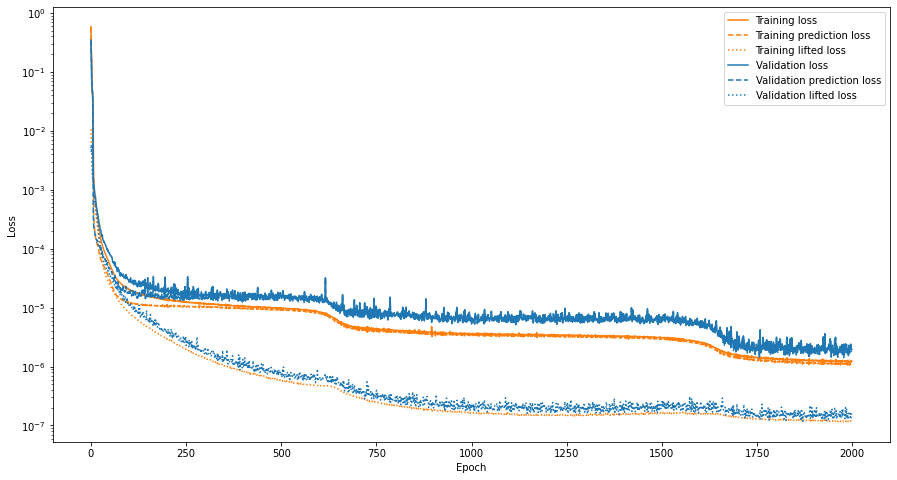

In [23]:
train_loss = [l[0] for l in model_koop_dnn.train_loss_hist]
train_pred_loss = [l[1] for l in model_koop_dnn.train_loss_hist]
train_lifted_loss = [l[2] for l in model_koop_dnn.train_loss_hist]
val_loss = [l[0] for l in model_koop_dnn.val_loss_hist]
val_pred_loss = [l[1] for l in model_koop_dnn.val_loss_hist]
val_lifted_loss = [l[2] for l in model_koop_dnn.val_loss_hist]
epochs = np.arange(0, net_params['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.savefig("convergence plot for arch1")
plt.show()


In [16]:
"""CREATE A NEURAL NETWORK TO MAP FROM THETA TO POSITION OF END EFFECTOR"""
class map_Net(nn.Module):

    def __init__(self,map_net_params):
        super(map_Net, self).__init__()
        self.map_net_params = map_net_params
        self.opt_parameters_map = []



    def create_model(self):
        input_dim = self.map_net_params['input_dim']
        hidden_depth = self.map_net_params['hidden_depth']
        hidden_width = self.map_net_params['hidden_width']
        output_dim = self.map_net_params['output_dim']
        activation_type = self.map_net_params['activation_type']


        if hidden_depth>0:
            #input_layer
            self.map_net_in = nn.Linear(input_dim,hidden_width)
            self.opt_parameters_map.append(self.map_net_in.weight)
            self.opt_parameters_map.append(self.map_net_in.bias)
            self.map_net_hid = nn.ModuleList()

            #hidden layers
            for i in range(1,hidden_depth):
                self.map_net_hid.append(nn.Linear(hidden_width,hidden_width))
                self.opt_parameters_map.append(self.map_net_hid[-1].weight)
                self.opt_parameters_map.append(self.map_net_hid[-1].bias)


            self.map_net_out = nn.Linear(hidden_width,output_dim)
            self.opt_parameters_map.append(self.map_net_out.weight)
            self.opt_parameters_map.append(self.map_net_out.bias)


        else: #no hidden layers
            self.map_net_out = nn.Linear(input_dim,output_dim)
            self.opt_parameters_map.append(self.map_net_out.weight)
            self.opt_parameters_map.append(self.map_net_out.bias)


        #activation functions
        if activation_type == 'relu':
            self.activation_fcn = F.relu

        if activation_type == 'elu':
            self.activation_fcn = nn.ELU

        if activation_type == 'tanh':
            self.activation_fcn = torch.tanh

        if activation_type == 'sigmoid':
            self.activation_fcn = torch.sigmoid

        else:
            exit("Exit : invalid activation function")


    def forward(self, theta):
        #this computes the forward operations
        if self.map_net_params['hidden_depth']>0:
            x = self.activation_fcn(self.map_net_in(theta))

            for layer in self.map_net_hid:
                x = self.activation_fcn(layer(x))

        x = self.map_net_out(x)

        return x


    def set_optimizer(self):
        if self.map_net_params['optimizer']=='adam':
            lr = self.map_net_params['lr']
            weight_decay = self.map_net_params['l2_reg']
            self.optimizer = optim.Adam(self.parameters(),lr = lr, weight_decay = weight_decay)
        elif self.map_net_params['optimizer']=='adamax':
            lr = self.map_net_params['lr']
            weight_decay = self.map_net_params['l2_reg']
            self.optimizer = optim.Adamax(self.parameters(),lr = lr, weight_decay = weight_decay)


    def loss(self,output, label):
        criterion = nn.MSELoss()
        loss = criterion(output,label)
        #l1 regularization
        l1_reg = map_net_params['l1_reg']
        l1_norm = torch.norm(self.map_net_in.weight.view(-1),p=1)+torch.norm(self.map_net_in.bias.view(-1),p=1)+torch.norm(self.map_net_out.weight.view(-1),p=1)+torch.norm(self.map_net_out.bias.view(-1),p=1)
        for i in range(0,self.map_net_params['hidden_depth']-1):
            l1_norm+= torch.norm(self.map_net_hid[i].weight.view(-1),p=1)+torch.norm(self.map_net_hid[i].bias.view(-1),p=1)

        l1_loss = l1_reg*l1_norm
        total_loss = loss+l1_loss

        return total_loss


    def set_dataset_map(self,xs_map_train,ys_map_train,xs_map_val,ys_map_val):
        order = 'F'
        n = self.map_net_params['input_dim'] #number of angles
        m = self.map_net_params['output_dim'] #x and y position of end effector
        n_traj_train = xs_map_train.shape[0]
        n_traj_val = int(0.25*n_traj_train)
        n_data_pts_train = n_traj_train*xs_map_train.shape[1]
        n_data_pts_val = n_traj_val*xs_map_train.shape[1]

        self.xs_map_train = xs_map_train.T.reshape((n,n_data_pts_train),order=order)
        self.ys_map_train = ys_map_train.T.reshape((m,n_data_pts_train),order=order)
        self.xs_map_val = xs_map_val.T.reshape((n,n_data_pts_val),order=order)
        self.ys_map_val = ys_map_val.T.reshape((m,n_data_pts_val),order=order)

        self.xs_map_train= self.xs_map_train.T
        self.xs_map_val= self.xs_map_val.T
        self.ys_map_train= self.ys_map_train.T
        self.ys_map_val= self.ys_map_val.T

    def data_pipeline(self):
        self.create_model()
        self.set_optimizer()
        X_map_train_t, y_map_train_t = torch.from_numpy(self.xs_map_train).float(), torch.from_numpy(self.ys_map_train).float()
        X_map_val_t, y_map_val_t = torch.from_numpy(self.xs_map_val).float(), torch.from_numpy(self.ys_map_val).float()
        dataset_train = torch.utils.data.TensorDataset(X_map_train_t, y_map_train_t)
        dataset_val = torch.utils.data.TensorDataset(X_map_val_t, y_map_val_t)

        self.train_map_model(dataset_train,dataset_val)


    def train_map_model(self,dataset_train,dataset_val):
        # Train Network
        trainloader = torch.utils.data.DataLoader(dataset_train, batch_size = self.map_net_params['batch_size'], shuffle = True)
        valloader = torch.utils.data.DataLoader(dataset_val, batch_size = self.map_net_params['batch_size'])

        val_loss_prev = np.inf
        self.train_loss_hist = []
        self.val_loss_hist = []
        for epoch in range(self.map_net_params['epochs']):
            running_loss = 0.0
            epoch_steps = 0

            for data in trainloader:
                inputs, labels = data

                self.optimizer.zero_grad()
                output = self(inputs)
                loss = self.loss(output,labels)
                loss.backward()
                self.optimizer.step()

                running_loss += float(loss.detach())
                epoch_steps += 1

            val_loss = 0.0
            val_steps =0

            for data in valloader:
                with torch.no_grad():
                    inputs, val_labels = data

                    val_output = self(inputs)
                    loss= self.loss(val_output,val_labels)

                    val_loss += float(loss.detach())
                    val_steps += 1

            #print epoch loss

            self.train_loss_hist.append(running_loss/epoch_steps)
            self.val_loss_hist.append(val_loss/val_steps)
            print('Epoch %3d: train loss: %.10f, validation loss: %.10f' %(epoch + 1, self.train_loss_hist[-1],self.val_loss_hist[-1]))

        print("Finished training")

    def plot_loss(self):
        #plot
        epochs = np.arange(0, self.map_net_params['epochs'])
        plt.figure(figsize=(15,8))
        plt.plot(epochs, self.train_loss_hist, color='tab:orange', label='Training loss')
        plt.plot(epochs, self.val_loss_hist, color='tab:blue', label='Validation loss')

        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')
        plt.show()

In [17]:
map_net_params = {}
map_net_params["input_dim"] = 3 #number of joint angles
map_net_params["output_dim"] = 2 #x and y position of the end effector
map_net_params["hidden_width"] = 20
map_net_params["hidden_depth"] = 2
map_net_params["batch_size"] = 200
map_net_params["epochs"] = 2000
map_net_params["activation_type"] = 'tanh'
map_net_params["lr"] = 1e-3
map_net_params["optimizer"] = 'adam'
map_net_params['l2_reg'] = 0.0
map_net_params['l1_reg'] = 0.0

In [18]:
#dataset
# split training and vaidation datasets
xs_map_train, ys_map_train = X_full[:num_train,:,0:3],X_end[:num_train,:,:]
xs_map_val, ys_map_val = X_full[num_train:,:,0:3],X_end[num_train:,:,:]

Epoch   1: train loss: 0.0657161211, validation loss: 0.0462362293
Epoch   2: train loss: 0.0091923929, validation loss: 0.0238663630
Epoch   3: train loss: 0.0047039261, validation loss: 0.0212224303
Epoch   4: train loss: 0.0032348642, validation loss: 0.0190370637
Epoch   5: train loss: 0.0023000176, validation loss: 0.0163768762
Epoch   6: train loss: 0.0016707976, validation loss: 0.0148264006
Epoch   7: train loss: 0.0012808133, validation loss: 0.0131599179
Epoch   8: train loss: 0.0010348331, validation loss: 0.0120218960
Epoch   9: train loss: 0.0008757283, validation loss: 0.0121506669
Epoch  10: train loss: 0.0007509751, validation loss: 0.0113896826
Epoch  11: train loss: 0.0006503928, validation loss: 0.0103842273
Epoch  12: train loss: 0.0005736557, validation loss: 0.0104188992
Epoch  13: train loss: 0.0005004361, validation loss: 0.0105672004
Epoch  14: train loss: 0.0004469098, validation loss: 0.0097422022
Epoch  15: train loss: 0.0004106660, validation loss: 0.009436

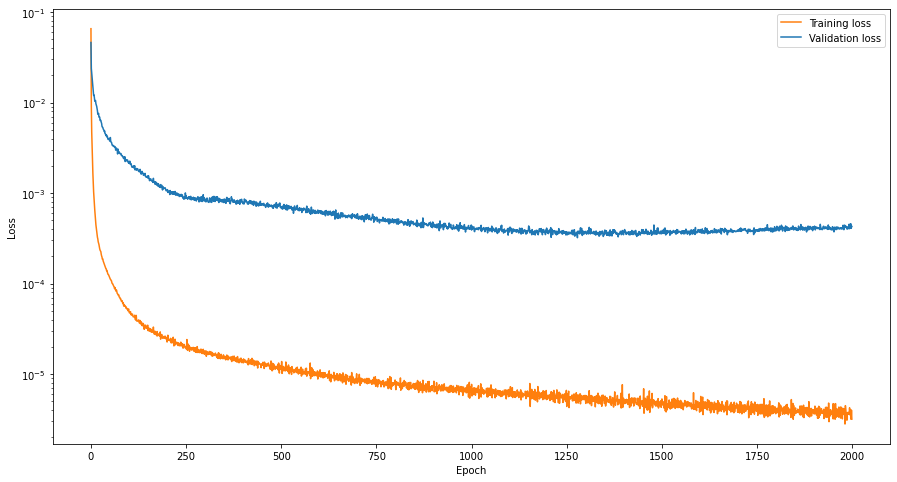

In [19]:
#Initalize network
train = True

if train==True:
    file = "map_net_arch1[3,20,20,2].pth"
    map_net = map_Net(map_net_params)
    map_net.set_dataset_map(xs_map_train,ys_map_train,xs_map_val,ys_map_val)
    map_net.data_pipeline()
    map_net.plot_loss()
    torch.save(map_net.state_dict(),file)
else:
    file = "map_net_arch1[3,20,20,2].pth"
    map_net = map_Net(map_net_params)
    map_net.load_state_dict(torch.load(file))


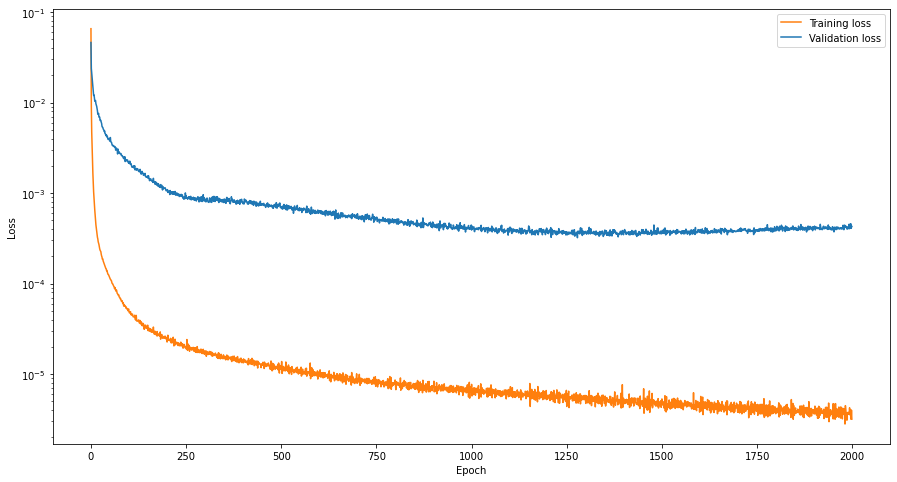

In [20]:
epochs = np.arange(0, map_net_params['epochs'])
plt.figure(figsize=(15,8))
plt.plot(epochs, map_net.train_loss_hist, color='tab:orange', label='Training loss')
plt.plot(epochs, map_net.val_loss_hist, color='tab:blue', label='Validation loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.savefig("convergence plot of map net for arch1[3,20,20,2]")
plt.show()

In [ ]:
import scipy.io

#save net parameters
scipy.io.savemat("map_in_weights.mat", {"map_in_weights": map_net.map_net_in.weight.detach().numpy()})
scipy.io.savemat("map_in_bias.mat", {"map_in_bias": map_net.map_net_in.bias.detach().numpy()})

scipy.io.savemat("map_hidden_weights_1.mat",
                 {"map_hidden_weights_1": map_net.map_net_hid[0].weight.detach().numpy()})
scipy.io.savemat("map_hidden_bias_1.mat",
                 {"map_hidden_bias_1": map_net.map_net_hid[0].bias.detach().numpy()})

scipy.io.savemat("map_hidden_weights_2.mat",
                 {"map_hidden_weights_2": map_net.map_net_hid[1].weight.detach().numpy()})
scipy.io.savemat("map_hidden_bias_2.mat",
                 {"map_hidden_bias_2": map_net.map_net_hid[1].bias.detach().numpy()})

scipy.io.savemat("map_hidden_weights_3.mat",
                 {"map_hidden_weights_3": map_net.map_net_hid[2].weight.detach().numpy()})
scipy.io.savemat("map_hidden_bias_3.mat",
                 {"map_hidden_bias_3": map_net.map_net_hid[2].bias.detach().numpy()})

scipy.io.savemat("map_out_weights.mat", {"map_out_weights": map_net.map_net_out.weight.detach().numpy()})
scipy.io.savemat("map_out_bias.mat", {"map_out_bias": map_net.map_net_out.bias.detach().numpy()})

## Test Data Parameters

In [59]:
# test data parameters
num_snaps_val = 2000 # no. of snapshots
T = np.linspace(0,num_snaps_val*dt, num_snaps_val+1)
num_traj_val = 1 # no. of training examples
first_obs_const = int(net_params['first_obs_const']) #only one state
override_C = net_params['override_C']
if override_C:
    n_obs = int(net_params['encoder_output_dim']) + num_states + first_obs_const 
else:
    n_obs = int(net_params['encoder_output_dim']) + first_obs_const 

***Koopman Bilinear Model***


In [31]:
A = np.array(model_koop_dnn.A)
#B = np.array(model_koop_dnn.B).reshape(-1,num_inputs*n_obs)
B = np.array(model_koop_dnn.B)
#B_tensor = np.empty((num_inputs,n_obs, n_obs))
#for ii, b in enumerate(B):
    #B_tensor[ii] = b
C = np.array(model_koop_dnn.C)

print(A.shape, B.shape, C.shape)

(17, 17) (17, 51) (6, 17)


In [ ]:
#SAVE MATRIX PARAMETERS AS MATLAB FILE
import scipy.io

dyn_matrices = {"A": A, "B": B, "C": C}
scipy.io.savemat("dyn_mat.mat", dyn_matrices)
#save encoder parameters
scipy.io.savemat("in_weights.mat", {"encode_in_weights": model_koop_dnn.net.encoder_fc_in.weight.detach().numpy()})
scipy.io.savemat("in_bias.mat", {"encode_in_bias": model_koop_dnn.net.encoder_fc_in.bias.detach().numpy()})

scipy.io.savemat("hidden_weights_1.mat",
                 {"encode_hidden_weights_1": model_koop_dnn.net.encoder_fc_hid[0].weight.detach().numpy()})
scipy.io.savemat("hidden_bias_1.mat",
                 {"encode_hidden_bias_1": model_koop_dnn.net.encoder_fc_hid[0].bias.detach().numpy()})

scipy.io.savemat("hidden_weights_2.mat",
                 {"encode_hidden_weights_2": model_koop_dnn.net.encoder_fc_hid[1].weight.detach().numpy()})
scipy.io.savemat("hidden_bias_2.mat",
                 {"encode_hidden_bias_2": model_koop_dnn.net.encoder_fc_hid[1].bias.detach().numpy()})

scipy.io.savemat("out_weights.mat", {"encode_out_weights": model_koop_dnn.net.encoder_fc_out.weight.detach().numpy()})
scipy.io.savemat("out_bias.mat", {"encode_out_bias": model_koop_dnn.net.encoder_fc_out.bias.detach().numpy()})

In [ ]:
encode_out_bias = model_koop_dnn.net.encoder_fc_out.bias.detach().numpy()
encode_out_weights = model_koop_dnn.net.encoder_fc_out.weight.detach().numpy()

***Test Data Generation***

In [47]:
# data_gen
xs_end_test,xs_test, us_test = dataset_dyn_gen_3R(dt,num_traj_val, num_snaps_val,num_states,num_inputs, robot_pars)

In [33]:
print(model_koop_dnn.test_loss(xs_test,u_test = us_test))

tensor(2.8247e-05)


In [34]:
basis = model_koop_dnn.net.encode_forward_

In [35]:
X,_ = model_koop_dnn.net.process(xs_test,data_u = us_test)
print(X.shape)

(2000, 15)


In [36]:
x = X[:, :num_states]
u = X[:, num_states:num_states+num_inputs]
x_prime = X[:,num_states+num_inputs:]

print(x.shape, u.shape, x_prime.shape)

(2000, 6) (2000, 3) (2000, 6)


***Initial Condition Lifting***

In [37]:
def lift(x,model_koop_dnn, first_obs_const, override_C):
    if first_obs_const == 1:
        if override_C:
            Z = np.concatenate((np.ones((1,)),x,model_koop_dnn.net.encode_forward_(torch.from_numpy(x).float()).detach().numpy()))
        else:
            Z = np.concatenate((np.ones((1,)),model_koop_dnn.net.encode_forward_(torch.from_numpy(x).float()).detach().numpy()))
    else:
        if override_C:
            Z = np.concatenate((x,model_koop_dnn.net.encode_forward_(torch.from_numpy(x).float()).detach().numpy()))
        else:
            Z = (model_koop_dnn.net.encode_forward_(torch.from_numpy(x).float()).detach().numpy())
    return Z

In [38]:
# initialize the matricies
z = np.empty((n_obs,num_snaps_val+1)).T
x_est = np.zeros((num_states,num_snaps_val+1)).T

In [39]:
z[0,:] = lift(x[0,:],model_koop_dnn, first_obs_const, override_C)
x_est[0,:] = x[0,:]

***Time Evolution***

In [40]:
for i in range(num_snaps_val):
  #bilinear
    z[i+1,:] = np.matmul(z[i,:],A.T)+np.matmul(np.kron(u[i,:],z[i,:]),B.T)
    x_est[i+1,:] = np.matmul(z[i+1,:],C.T)     

In [ ]:
# theta to end effector positions
# Function for dynamics
def cartesian_pos_gen_3R(th_data, robot_pars):
    #define parameters
    # link lengths
    a1 = robot_pars['a1']
    a2 = robot_pars['a2']
    a3 = robot_pars['a3']
    #link masses
    m1 = robot_pars['m1']
    m2 = robot_pars['m2']
    m3 = robot_pars['m3']
    # link inertias
    I1 = robot_pars['I1']
    I2 = robot_pars['I2']
    I3 = robot_pars['I3']
    #position of CM
    l1 = robot_pars['l1']
    l2 = robot_pars['l2']
    l3 = robot_pars['l3']

    
    # X  = rows are joint and effector positions and velocities
    num_states = 2*th_data.shape[1]
    num_snaps = th_data.shape[0]
    X = np.empty((num_snaps,num_states)) # cartesian state matrix

    for i in range(num_snaps):
        # time evolution
        X[i,0] = a1*np.cos(th_data[i,0]) + a2*np.cos(th_data[i,0]+th_data[i,1])+a3*np.cos(th_data[i,0]+th_data[i,1]+th_data[i,2]) # end_eff_x
        X[i,1] = a1*np.sin(th_data[i,0]) + a2*np.sin(th_data[i,0]+th_data[i,1])+a3*np.sin(th_data[i,0]+th_data[i,1]+th_data[i,2]) # end_eff_y
        X[i,2] = a1*np.cos(th_data[i,0]) + a2*np.cos(th_data[i,0]+th_data[i,1]) # jt2_x
        X[i,3] = l1*np.sin(th_data[i,0]) + l2*np.sin(th_data[i,0]+th_data[i,1]) # jt2_y
        X[i,4] = l1*np.cos(th_data[i,0]) #jt1_x
        X[i,5] = l1*np.sin(th_data[i,0]) #jt1_y

        #joint velocities
        X[i,6] = -a1*np.sin(th_data[i,0])*th_data[i,3] - a2*np.sin(th_data[i,0]+th_data[i,1])*(th_data[i,3]+th_data[i,4])-a3*np.sin(th_data[i,0]+th_data[i,1]+th_data[i,2])*(th_data[i,3]+th_data[i,4]+th_data[i,5]) # end_eff_x
        X[i,7] = a1*np.cos(th_data[i,0])*th_data[i,3] + a2*np.cos(th_data[i,0]+th_data[i,1])*(th_data[i,3]+th_data[i,4])+a3*np.cos(th_data[i,0]+th_data[i,1]+th_data[i,2])*(th_data[i,3]+th_data[i,4]+th_data[i,5]) # end_eff_y
        X[i,8] = -a1*np.sin(th_data[i,0])*th_data[i,3] - a2*np.sin(th_data[i,0]+th_data[i,1])*(th_data[i,3]+th_data[i,4]) # end_eff_x
        X[i,9] = a1*np.cos(th_data[i,0])*th_data[i,3] + a2*np.cos(th_data[i,0]+th_data[i,1])*(th_data[i,3]+th_data[i,4]) # end_eff_y
        X[i,10] = -a1*np.sin(th_data[i,0])*th_data[i,3] #jt_x
        X[i,11] = a1*np.cos(th_data[i,0])*th_data[i,3] #jt_y
    return X

# Cartesian Positions

In [ ]:
x_cart = cartesian_pos_gen_3R(x, robot_pars)
x_cart_est = cartesian_pos_gen_3R(x_est, robot_pars)

***Visualization***

# Joint Space

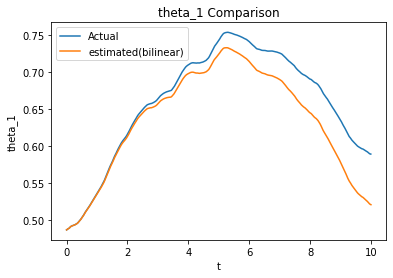

In [48]:
plt.figure()
plt.plot(T[:-1],x[:,0],label ='Actual')
plt.plot(T,x_est[:,0],label = 'estimated(bilinear)')
plt.xlabel('t')
plt.ylabel('theta_1')
plt.title('theta_1 Comparison')
plt.legend()

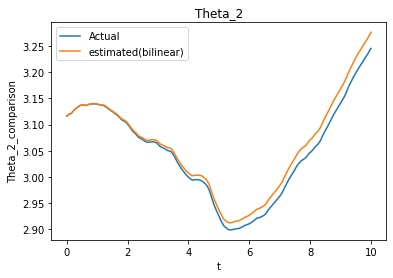

In [49]:
plt.figure()
plt.plot(T[:-1],x[:,1],label ='Actual')
plt.plot(T,x_est[:,1],label = 'estimated(bilinear)')
plt.title('Theta_2')
plt.xlabel('t')
plt.ylabel('Theta_2_comparison')
plt.legend()

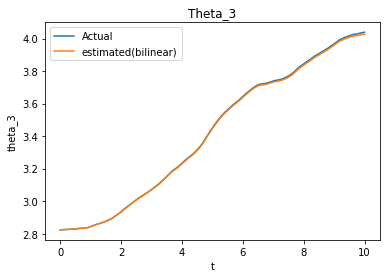

In [50]:

plt.figure()
plt.plot(T[:-1],x[:,2],label ='Actual')
plt.plot(T,x_est[:,2],label = 'estimated(bilinear)')
plt.title('Theta_3')
plt.xlabel('t')
plt.ylabel('theta_3')
plt.legend()

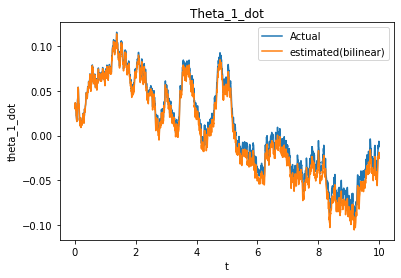

In [51]:
plt.figure()
plt.plot(T[:-1],x[:,3],label ='Actual')
plt.plot(T,x_est[:,3],label = 'estimated(bilinear)')
plt.title('Theta_1_dot')
plt.xlabel('t')
plt.ylabel('theta_1_dot')
plt.legend()

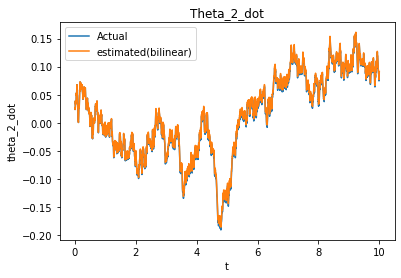

In [52]:
plt.figure()
plt.plot(T[:-1],x[:,4],label ='Actual')
plt.plot(T,x_est[:,4],label = 'estimated(bilinear)')
plt.title('Theta_2_dot')
plt.xlabel('t')
plt.ylabel('theta_2_dot')
plt.legend()

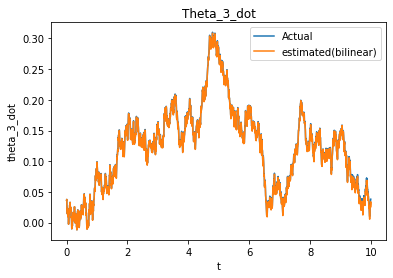

In [53]:
plt.figure()
plt.plot(T[:-1],x[:,5],label ='Actual')
plt.plot(T,x_est[:,5],label = 'estimated(bilinear)')
plt.title('Theta_3_dot')
plt.xlabel('t')
plt.ylabel('theta_3_dot')
plt.legend()

# Cartesian Space

In [60]:
plt.figure()
plt.plot(T[:-1],x_cart[:,0],label ='Actual')
plt.plot(T[:],x_cart_est[:,0],label = 'estimated(bilinear)')
plt.title('end effector x position comparison')
plt.xlabel('t')
plt.ylabel('x_1')
plt.legend()

NameError: name 'x_cart' is not defined

<Figure size 432x288 with 0 Axes>

In [61]:
plt.figure()
plt.plot(T[:-1],x_cart[:,1],label ='Actual')
plt.plot(T[:],x_cart_est[:,1],label = 'estimated(bilinear)')
plt.title('end effector y position comparison')
plt.xlabel('t')
plt.ylabel('y_1')
plt.legend()

NameError: name 'x_cart' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure()
plt.plot(x_cart[:,0],x_cart[:,1],label ='Actual')
plt.plot(x_cart_est[:,0],x_cart_est[:,1],label = 'estimated(bilinear)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('end effector position comparison')
plt.legend()

In [ ]:
plt.figure()
plt.plot(x_cart[:,2],x_cart[:,3],label ='Actual')
plt.plot(x_cart_est[:,2],x_cart_est[:,3],label = 'estimated(bilinear)')
plt.xlabel('j2_x')
plt.ylabel('j2_y')
plt.title('end effector of joint 2 position comparison')
plt.legend()

In [ ]:
plt.figure()
plt.plot(x_cart[:,4],x_cart[:,5],label ='Actual')
plt.plot(x_cart_est[:,4],x_cart_est[:,5],label = 'estimated(bilinear)')
plt.xlabel('j3_x')
plt.ylabel('j3_y')
plt.title('end effector position comparison of joint 3')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x_cart[:,6],label ='Actual')
plt.plot(T[:],x_cart_est[:,6],label = 'estimated(bilinear)')
plt.title('end effector x velocity position comparison')
plt.xlabel('t')
plt.ylabel('x_1_dot')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x_cart[:,7],label ='Actual')
plt.plot(T[:],x_cart_est[:,7],label = 'estimated(bilinear)')
plt.title('end effector y velocity position comparison')
plt.xlabel('t')
plt.ylabel('y_1_dot')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x_cart[:,8],label ='Actual')
plt.plot(T[:],x_cart_est[:,8],label = 'estimated(bilinear)')
plt.title('Joint 2 x velocity position comparison')
plt.xlabel('t')
plt.ylabel('x dot')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x_cart[:,9],label ='Actual')
plt.plot(T[:],x_cart_est[:,9],label = 'estimated(bilinear)')
plt.title('Joint 2 y velocity comparison')
plt.xlabel('t')
plt.ylabel('y dot')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x_cart[:,10],label ='Actual')
plt.plot(T[:],x_cart_est[:,10],label = 'estimated(bilinear)')
plt.title('Joint 1 x velocity comparison')
plt.xlabel('t')
plt.ylabel('x dot')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],x_cart[:,7],label ='Actual')
plt.plot(T[:],x_cart_est[:,7],label = 'estimated(bilinear)')
plt.title('Joint 1 y velocity position comparison')
plt.xlabel('t')
plt.ylabel('y dot')
plt.legend()

In [ ]:
plt.figure()
plt.plot(T[:-1],error_mse_joint_tot)
plt.xlabel('t')
plt.ylabel('error_mse_joint_tot')
plt.title('Total Joint space error evolution')
plt.savefig("output.jpg",format ='jpg', dpi = 100)

In [ ]:
plt.figure()
plt.plot(T[:-1],error_mse_joint_pos)
plt.xlabel('t')
plt.ylabel('error_mse_joint_pos')
plt.title('Joint position error evolution')
plt.savefig("output.jpg",format ='jpg', dpi = 100)

In [ ]:
plt.figure()
plt.plot(T[:-1],error_mse_joint_vel)
plt.xlabel('t')
plt.ylabel('error_mse_joint_vel')
plt.title('Joint vel error evolution')
plt.savefig("output.jpg",format ='jpg', dpi = 100)

In [ ]:
plt.figure()
plt.plot(T[:-1],error_mse_cart_tot)
plt.xlabel('t')
plt.ylabel('error_mse_cart_tot')
plt.title('Total cartesian space error evolution')

In [ ]:
plt.figure()
plt.plot(T[:-1],error_mse_cart_pos_ef)
plt.xlabel('t')
plt.ylabel('error_mse_cart_pos_ef')
plt.title('End Effector position error evolution')

In [ ]:
plt.figure()
plt.plot(T[:-1],error_mse_cart_vel_ef)
plt.xlabel('t')
plt.ylabel('error_mse_cart_vel_ef')
plt.title('End Effector vel error evolution')

In [62]:
# data_gen
xs_end_test,xs_test, us_test = dataset_dyn_gen_3R(dt,num_traj_val, num_snaps_val,num_states,num_inputs, robot_pars)

In [63]:
#testing the map network
theta_test = xs_test[:,:,0:3]
theta_test = theta_test.T.reshape((3,2001),order='F')
theta_test = theta_test.T
x_end_pred = np.empty((num_snaps_val+1,2))

In [64]:
for i in range(num_snaps_val):
    th_t = torch.from_numpy(theta_test[i,:]).float()
    x_end_pred[i,:] = map_net(th_t).detach().numpy()

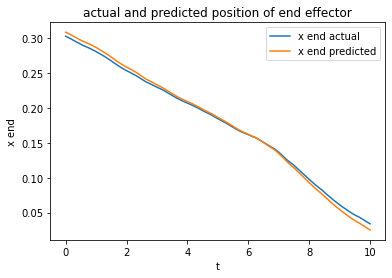

In [65]:

#plot
plt.figure()
plt.plot(T[:-1],xs_end_test[:,0:-1,0].T,label='x end actual')
plt.plot(T[:-1],x_end_pred[0:-1,0],label='x end predicted')
plt.xlabel('t')
plt.ylabel('x end')
plt.legend()
plt.title('actual and predicted position of end effector')
plt.show()

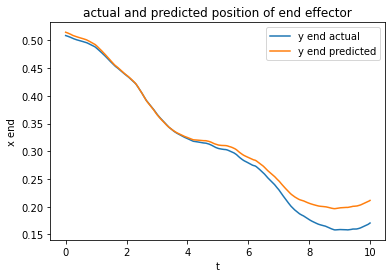

In [66]:
plt.figure()
plt.plot(T[:-1],xs_end_test[:,0:-1,1].T,label='y end actual')
plt.plot(T[:-1],x_end_pred[0:-1,1],label='y end predicted')
plt.xlabel('t')
plt.ylabel('x end')
plt.legend()
plt.title('actual and predicted position of end effector')
plt.show()

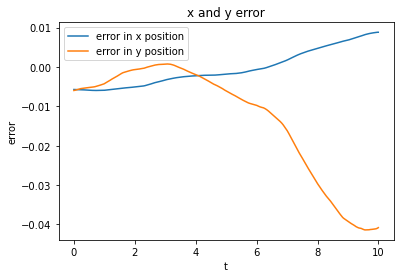

In [67]:
#error plot
plt.figure()
error_x = xs_end_test[:,0:-1,0]-x_end_pred[0:-1,0]
error_y = xs_end_test[:,0:-1,1]-x_end_pred[0:-1,1]
plt.plot(T[:-1],error_x.T,label='error in x position')
plt.plot(T[:-1],error_y.T,label='error in y position')
plt.xlabel('t')
plt.ylabel('error')
plt.legend()
plt.title('x and y error')
plt.show()

# Control of the bilinear model

In [ ]:
# continious matricies
# continious matricies
Ac = (A-np.eye(n_obs))/dt
Bc = B/dt
Cc = C
Crc = Cc[0:2,:]

In [ ]:
# control process pars
# test data parameters
t_con = 10
num_snaps_con = int(t_con/dt) # no. of snapshots
T = np.linspace(0,num_snaps_con*dt, num_snaps_con+1)

In [ ]:
# comparison of continious and discreate matricies
# initilizations
z_disc = np.empty((n_obs,num_snaps_con+1)).T
z_cont = np.empty((n_obs,num_snaps_con+1)).T
u = np.zeros((num_inputs,num_snaps_con)).T
# initial values
x = np.random.rand(1,num_states)

In [ ]:
z_disc[0,:] = lift(x[0,:],model_koop_dnn, first_obs_const, override_C)
z_cont[0,:] = z_disc[0,:]
u[0,:] = (2*np.random.rand(1,num_inputs)-1)

In [ ]:
for i in range(num_snaps_con):
  #bilinear
    u[i,:] = (2*np.random.rand(1,num_inputs)-1)
    z_disc[i+1,:] = np.matmul(z_disc[i,:],A.T)+np.matmul(np.kron(u[i,:],z_disc[i,:]),B.T)
    #z[i+1,:] = z[i,:] + z_dot[i,:]
    z_dot = np.matmul(z_cont[i,:],Ac.T)+np.matmul(np.kron(u[i,:],z_cont[i,:]),Bc.T)
    z_cont[i+1,:] = z_cont[i,:] + z_dot*dt

In [ ]:
error_disc = np.sqrt(np.square(z_cont-z_disc).mean(axis=1))

In [ ]:
plt.figure()
plt.plot(T[:],error_disc)
plt.xlabel('t')
plt.ylabel('error_disc')
plt.title('discreatization error evolution')

## Dynamics

In [ ]:
# theta to end effector positions
# Function for dynamics
def forward_kinematics_2r(th_data,th_dot_data, robot_pars):
    #define parameters
    # link lengths
    l1 = robot_pars['l1']
    l2 = robot_pars['l2']
    #link masses
    m1 = robot_pars['m1']
    m2 = robot_pars['m2']
    # link inertias
    I1 = robot_pars['I1']
    I2 = robot_pars['I1']
    # theta_data = (num_snaps, num_states)
    
    # X  = rows are joint and effector positions and velocities
    num_states = 4*th_data.shape[1]
    num_snaps = th_data.shape[0]
    X = np.empty((num_snaps,num_states)) # cartesian state matrix

    for i in range(num_snaps):
        # time evolution
        X[i,0] = l1*np.cos(th_data[i,0]) + l2*np.cos(th_data[i,0]+th_data[i,1]) # end_eff_x
        X[i,1] = l1*np.sin(th_data[i,0]) + l2*np.sin(th_data[i,0]+th_data[i,1]) # end_eff_y
        X[i,2] = l1*np.cos(th_data[i,0]) #jt_x
        X[i,3] = l1*np.sin(th_data[i,0]) #jt_y
        X[i,4] = -l1*np.sin(th_data[i,0])*th_dot_data[i,0] - l2*np.sin(th_data[i,0]+th_data[i,1])*(th_dot_data[i,0]+th_dot_data[i,1]) # end_eff_x
        X[i,5] = l1*np.cos(th_data[i,0])*th_dot_data[i,0] + l2*np.cos(th_data[i,0]+th_data[i,1])*(th_dot_data[i,0]+th_dot_data[i,1]) # end_eff_y
        X[i,6] = -l1*np.sin(th_data[i,0])*th_dot_data[i,0] #jt_x
        X[i,7] = l1*np.cos(th_data[i,0])*th_dot_data[i,0] #jt_y
    return X

In [ ]:
# theta to end effector positions
# Function for dynamics
def forward_map_2r(th_data, robot_pars):
    #define parameters
    # link lengths
    l1 = robot_pars['l1']
    l2 = robot_pars['l2']
    #link masses
    m1 = robot_pars['m1']
    m2 = robot_pars['m2']
    # link inertias
    I1 = robot_pars['I1']
    I2 = robot_pars['I1']
    # theta_data = (num_snaps, num_states)
    
    # X  = rows are joint and effector positions and velocities
    num_states = 4
    num_snaps = 1
    X = np.empty((num_states,)) # cartesian state matrix

    # time evolution
    X[0] = l1*np.cos(th_data[0]) + l2*np.cos(th_data[0]+th_data[1]) # end_eff_x
    X[1] = l1*np.sin(th_data[0]) + l2*np.sin(th_data[0]+th_data[1]) # end_eff_y
    X[2] = l1*np.cos(th_data[0]) #jt_x
    X[3] = l1*np.sin(th_data[0]) #jt_y  
    
    return X

In [ ]:
def Jacobian_2r(th_data, robot_pars):
    #define parameters
    # link lengths
    l1 = robot_pars['l1']
    l2 = robot_pars['l2']
    #link masses
    m1 = robot_pars['m1']
    m2 = robot_pars['m2']
    # link inertias
    I1 = robot_pars['I1']
    I2 = robot_pars['I1']
    # theta_data = (num_snaps, num_states)
    
    # X  = rows are joint and effector positions and velocities
    J = np.empty((2,2)) # cartesian state matrix

    # time evolution
    J[0,0] = -l1*np.sin(th_data[0]) - l2*np.sin(th_data[0]+th_data[1]) # end_eff_x
    J[0,1] = -l2*np.sin(th_data[0]+th_data[1])
    J[1,0] = l1*np.cos(th_data[0]) + l2*np.cos(th_data[0]+th_data[1])
    J[1,1] = l2*np.cos(th_data[0]+th_data[1])
    
    return J

In [ ]:
#function for dynamics in tau to theta conversion
def dynamics_2R(dt, u, th, th_dot, robot_pars):
    #define parameters
    # link lengths
    l1 = robot_pars['l1']
    l2 = robot_pars['l2']
    #link masses
    m1 = robot_pars['m1']
    m2 = robot_pars['m2']
    # link inertias
    I1 = robot_pars['I1']
    I2 = robot_pars['I1']

    # gravity
    g = 9.81*0
    # matrix initializations
    tau = u.reshape(-1,1)
    # mass matrix
    m11 = (I1+I2+m1*l1**2) + (m2*l2**2/4+m1*l1**2)/4 + (2*m2*l1*l2*np.cos(th[1]));
    m12 = I2+(m2*l2**2)/4 + m2*l1*l2*np.cos(th[1])/2;
    m21=m12;
    m22 = I2 + (m2*l2**2)/4;

    M = np.array([[m11,m12],[m21,m22]])

    # coriolis tersms
    c1 = -m2*l1*l2*0.5*np.sin(th[1])*(2*th_dot[0]*th_dot[1]+th_dot[1]**2);
    c2 = m2*l1*l2*np.sin(th[1])*th_dot[1]**2;

    C = np.array([[c1],[c2]]) 

    # gravity terms     
    g1 = m2*g*(l1*np.cos(th[0])+l2*np.cos(th[0]+th[1]))+m1*g*l1*0.5*np.cos(th[0]);
    g2 = m2*g*l2*0.5*np.cos(th[0]+th[1]);

    G = np.array([[g1],[g2]]) 

    # inputs
    
    # theta evolution
    th_ddot = np.matmul(np.linalg.inv(M),(tau-G-C)).reshape(2,)
    th_dot_next = th_dot + th_ddot*dt
    th_next = th + th_dot*dt + (1/2)*th_ddot*dt**2

    return th_next, th_dot_next

## Noise Generation

In [ ]:
def gen_noise(t,amp,state,noise_nature):
    num_states = int(state.shape[0])
    noise = np.empty((1,num_states))
    if noise_nature == 'constant':
        noise[0,:] = np.ones((1,num_states))*ep
    elif noise_nature == 'sinosoidal':
        for j in range(num_states):
            if j%2 == 0:
                noise[0,j] = ep*np.sin(4*np.pi*t)
            else:
                noise[0,j] = ep*np.cos(4*np.pi*t)
    elif noise_nature == 'state_dependent':
        noise[0,0] = ep*np.sin(4*np.pi*t*state[0])
        noise[0,1] = ep*np.cos(4*np.pi*t*state[0])
        noise[0,2] = ep*np.sin(4*np.pi*t)
        noise[0,3] = ep*np.cos(4*np.pi*t)
    else:
        noise[0,:] = np.zeros((1,num_states))
    return noise
        
        

## Control Parameters

In [ ]:
# initialize parameters
# control process pars
t_run = 10
n_p = 1 #no of periods
t_sim = n_p*t_run 
num_snaps_sim = int(t_sim/dt) # no. of snapshots
T = np.linspace(0,num_snaps_sim*dt, num_snaps_sim+1)
num_cont_outs = 2 # no of controllable outputs
gamma_traced = 10
gamma_res = 40

l = 1
c = 0.02;

# noise parameters
noise = False
noise_nature = 'constant'
if noise:
    ep = 0.01 # amplitude of noise
else:
    ep = 0

In [ ]:
#initialize matricies
# comparison of continious and discreate matricies
# initilizations
z = np.empty((n_obs,num_snaps_sim+1)).T # from the measurement
z_dot_est = np.empty((n_obs,num_snaps_sim)).T # from the measurement
z_dot_actual = np.empty((n_obs,num_snaps_sim)).T # from the measurement
z_m = np.empty((n_obs,num_snaps_sim+1)).T # from the model
u = np.zeros((num_inputs,num_snaps_sim)).T
#
# initial values
th = np.zeros((num_states,num_snaps_sim+1)).T #[th th_dot]
th_actual = np.empty((num_states,num_snaps_sim+1)).T
# considering only the end effecctor
x_desired = np.empty((num_cont_outs,num_snaps_sim+1)).T
x_desired_dot = np.empty((num_cont_outs,num_snaps_sim+1)).T
x_traced = np.empty((num_cont_outs,num_snaps_sim+1)).T
x_actual = np.empty((num_cont_outs,num_snaps_sim+1)).T
error_traced = np.zeros((num_cont_outs,num_snaps_sim)).T
#considering the full state matrix
x_actual = np.empty((num_states,num_snaps_sim+1)).T
noise = np.empty((num_states,num_snaps_sim+1)).T #full states
# residual initialization
rd = np.empty((n_obs,num_snaps_sim+1)).T
rd_dot = np.empty((n_obs,num_snaps_sim)).T

In [ ]:
# set initial values
th[0,:2] = np.array([0.1, np.pi*0.9])
th[0,2:4] = np.zeros((2,))
# end effector quantities
x_actual[0,:] = forward_map_2r(th[0,:2],robot_pars)
print(x_actual[0,:])

#noise addition
noise[0,:] = gen_noise(0,ep,x_actual[0,:],noise_nature)
x_actual[0,:] += noise[0,:]
print(x_actual[0,:])
x_traced[0,:] = x_actual[0,:2]
x_desired[0,:] = x_traced[0,:]


# inputs
u[0,:] = np.zeros((1,num_inputs))
x_desired_dot[0,0] = -2*c*2*np.pi*np.sin(2*np.pi*0/t_run)/t_run+c*4*np.pi*np.sin(4*np.pi*0/t_run)/t_run;
x_desired_dot[0,1] =  2*c*2*np.pi*np.cos(2*np.pi*0/t_run)/t_run-c*4*np.pi*np.cos(4*np.pi*0/t_run)/t_run

#lifted quantities
z[0,:] = lift(th[0,:],model_koop_dnn, first_obs_const, override_C) # estimated lifed state        
z_m[0,:] = z[0,:]
# residual
rd[0,:] = np.zeros((n_obs,1)).T

In [ ]:
for i in range(num_snaps_sim):
  #bilinear
    t = T[i+1]
    # desired positions
    x_desired[i+1,0] = 2*c*np.cos(2*np.pi*t/t_run)-c*np.cos(4*np.pi*t/t_run) + x_desired[0,0] - c
    x_desired[i+1,1] = 2*c*np.sin(2*np.pi*t/t_run)-c*np.sin(4*np.pi*t/t_run) + x_desired[0,1]
    # desirded velocities
    x_desired_dot[i+1,0] = -2*c*2*np.pi*np.sin(2*np.pi*t/t_run)/t_run+c*4*np.pi*np.sin(4*np.pi*t/t_run)/t_run;
    x_desired_dot[i+1,1] =  2*c*2*np.pi*np.cos(2*np.pi*t/t_run)/t_run-c*4*np.pi*np.cos(4*np.pi*t/t_run)/t_run
    
    # tracking error
    error_traced[i,:] = x_actual[i,0:2] - x_desired[i,:]
    u[i,:] = np.matmul(np.linalg.pinv(np.matmul(Jacobian_2r(th[i,:2], robot_pars),
                np.matmul(Crc,np.matmul(Bc,np.kron(np.identity(2),z[i,:]).T)))),
                (x_desired_dot[i,:].T - np.matmul(Jacobian_2r(th[i,:2],robot_pars),
                np.matmul(Crc,np.matmul(Ac,z[i,:].T))) - np.matmul(Jacobian_2r(th[i,:2],robot_pars),
                np.matmul(Crc,rd[i,:].T)) 
                 - gamma_traced*error_traced[i,:].T))                                    
    
    
    #u[i,:] = gamma_traced*error_traced[i,:].T # proportional control
    # lifted state velocities
    z_dot_est[i,:] = np.matmul(z[i,:],Ac.T) + np.matmul(np.kron(u[i,:],z[i,:]),Bc.T) + rd[i,:]
    if i == 0:
        z_dot_actual[i,:] = np.zeros((1,n_obs))
    else:
        z_dot_actual[i,:] = (z[i,:]-z[i-1,:])/dt
    
    rd_dot[i,:] = gamma_res*(z_dot_actual[i,:] - z_dot_est[i-1,:])
    rd[i+1,:] = rd[i,:] + rd_dot[i,:]*dt
    

    
   # next state raise
    th[i+1,:2],th[i+1,2:] = dynamics_2R(dt, u[i,:], th[i,:2], th[i,2:], robot_pars)
    z[i+1,:] = lift(th[i+1,:],model_koop_dnn, first_obs_const, override_C)
    x_actual[i+1,:] = forward_map_2r(th[i+1,:2],robot_pars)
    noise[i+1,:] = gen_noise(t,ep,x_actual[i+1,:],noise_nature)
    x_actual[i+1,:] += noise[i+1,:]
    
    # model states
    z_m[i+1,:] = z[i,:] + z_dot_est[i,:]*dt            
    th_traced_full = np.matmul(z_m[i+1,:],Crc.T)
    x_traced_full = forward_map_2r(th_traced_full[:2],robot_pars)
    x_traced[i+1,:] = x_traced_full[:2]

In [ ]:
print(A)

In [ ]:
plt.figure()
plt.plot(x_desired[:,0],x_desired[:,1],label ='desired')
plt.plot(x_traced[:,0],x_traced[:,1],'r--',label = 'esimated(bilinear)', )
plt.xlabel('x')
plt.ylabel('y')
plt.title('end effector position comparison')
plt.legend()

In [ ]:
plt.figure()
plt.plot(x_desired[:,0],x_desired[:,1],label ='desired')
plt.plot(x_actual[:,0],x_actual[:,1],'r--',label = 'Actual Model' )
plt.xlabel('x')
plt.ylabel('y')
plt.title('end effector position comparison')
plt.legend()

In [ ]:
plt.figure()
plt.plot(x_actual[:,0],x_actual[:,1],label ='Actual')
plt.plot(x_traced[:,0],x_traced[:,1],'r--',label = 'esimated(bilinear)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('end effector position comparison')
plt.legend()

In [ ]:
u_norm = np.sqrt(np.square(u).mean(axis=1))

In [ ]:
plt.figure()
plt.plot(T[:-1],u_norm)
plt.xlabel('t')
plt.ylabel('||u||')
plt.title('control norm evolution')

In [ ]:
plt.figure()
plt.plot(T,x_actual[:,0],label = 'x')
plt.plot(T,x_actual[:,1],label = 'y')

In [ ]:
error_model = np.sqrt(np.square(x_traced-x_actual[:,:2]).mean(axis=1))
error_tracking = np.sqrt(np.square(x_actual[:,:2]-x_desired).mean(axis=1))

In [ ]:
plt.figure()
plt.plot(T[:],error_model)
plt.xlabel('t')
plt.ylabel('error_model')
plt.title('model error evolution')

In [ ]:
plt.figure()
plt.plot(T[:],error_tracking)
plt.xlabel('t')
plt.ylabel('error_track')
plt.title('tracking error evolution')

In [ ]:
z_norm = np.sqrt(np.square(z).mean(axis=1))
x_norm = np.sqrt(np.square(x_actual).mean(axis=1))
noise_norm = np.sqrt(np.square(noise).mean(axis=1))

In [ ]:
plt.figure()
plt.plot(T[:],x_norm)
plt.xlabel('t')
plt.ylabel('||x||')
plt.title('x norm evolution')

In [ ]:
plt.figure()
plt.plot(T[:],z_norm)
plt.xlabel('t')
plt.ylabel('||z||')
plt.title('z norm evolution')

In [ ]:
plt.figure()
plt.plot(T[:],noise_norm)
plt.xlabel('t')
plt.ylabel('error_model')
plt.title('noise norm evolution')

In [ ]:
lift(np.array([-1,2,-3,7.4]),model_koop_dnn,first_obs_const,override_C)